# Projects

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.in2p3.fr%2Fenergy4climate%2Fpublic%2Feducation%2Fmachine_learning_for_climate_and_energy/master?filepath=book%2Fnotebooks%2Fprojects.ipynb)

<div class="alert alert-block alert-warning">
    <b>Schedule</b>
    
- Ask your supervisors for the data if not already provided (it is not included in this repository).
- Quick presentation.
- Final project presentation.
    
</div>

<div class="alert alert-block alert-info">
    <b>One problematic, One dataset, One (or more) method(s)</b>
    
- Quality of the dataset is key.
- Results on a clean notebook.
- Explain which method(s) you used and why.
- If a method fails, explain why.

</div>

## Project: Weather station

- Suppose there are 5 weather stations that monitor the weather: Paris, Brest, London, Marseille and Berlin.
- The weather station in Paris breaks down
- Can we use the other stations to infer the weather in Paris?

<img alt="weather" src="images/map.png" width=400>

### Dataset

<img alt="weather" src="images/annual_temperature.png" width=400>

- Surface variables: skt, u10, v10, t2m, d2m, tcc, sp, tp, ssrd, blh
- Temporal resolution: hourly
- Spatial resolution: N/A

### First steps

- Look at the correlations between variables.
- What variable do I want to predict
- What time scale am interested in?
- Start with the easy predictions and move on to harder ones
- Are there events that are more predictable than others?

<Axes: xlabel='time'>

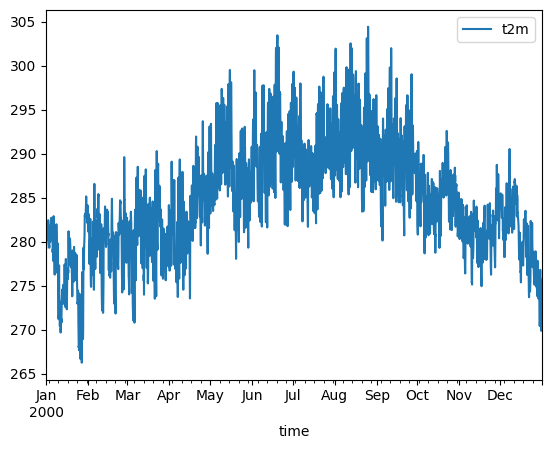

In [93]:
from pathlib import Path
import pandas as pd
import xarray as xr


import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

dir0 = Path('weather_data/paris/')
file_t2m = 't2m.nc'

ds = xr.open_dataset(Path(dir0, file_t2m))

# convert to pandas dataframe
df = ds.to_dataframe()

# remove latitude and longitude indices
df = df.droplevel([1,2])

df.loc['2000'].plot()

# Chargement et exploration du jeu de données

## Chargement des données

In [94]:
base_dir= Path("weather_data")

cities = ["paris", "brest", "marseille", "london", "berlin"]
var = "t2m"  # on commence par la température à 2m

In [95]:
def load_city_var(city: str, var: str = "t2m") -> pd.DataFrame:
    """
    Charge un fichier NetCDF pour une ville et une variable
    et renvoie un DataFrame pandas avec l'indice temporel
    et une seule colonne nommée var_city (ex: t2m_paris).
    """
    city_dir = base_dir / city
    file_path = city_dir / f"{var}.nc"
    print(f"Loading {file_path}")
    
    ds = xr.open_dataset(file_path)
    
    # Conversion en DataFrame
    df = ds.to_dataframe()
    
    # Si l'index est multi-index (time, lat, lon), on enlève lat/lon :
    # A adapter si ça plante : imprime df.index.names
    if isinstance(df.index, pd.MultiIndex):
        print("MultiIndex levels:", df.index.names)
        # on suppose l'ordre: time, latitude, longitude
        df = df.droplevel([1, 2])
    
    # garder uniquement la variable d'intérêt
    df = df[[var]].rename(columns={var: f"{var}_{city}"})
    
    return df


In [96]:
dfs = []

for city in cities:
    df_city = load_city_var(city, var=var)
    dfs.append(df_city)

# Fusion sur l'index temps (intersection des dates)
df_t2m = pd.concat(dfs, axis=1, join="inner").sort_index()


Loading weather_data\paris\t2m.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\brest\t2m.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\marseille\t2m.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\london\t2m.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\berlin\t2m.nc
MultiIndex levels: ['time', 'latitude', 'longitude']


## Premières observations

### Correlations 't2m'

,t2m_paris,t2m_brest,t2m_marseille,t2m_london,t2m_berlin
count,350640.000000,350640.000000,350640.000000,350640.000000,350640.000000
mean,284.363861,285.042114,288.001434,283.669647,282.741241
std,7.123538,4.206954,6.454230,5.922555,8.276498
min,256.771332,266.545654,266.325012,257.483673,251.373947
25%,279.320221,282.226852,283.138084,279.440552,276.518456
50%,284.179443,284.985764,287.711685,283.601471,282.662201
75%,289.236519,288.057495,293.046341,287.846313,288.725220
max,314.154785,304.947449,307.499115,308.787231,311.392822


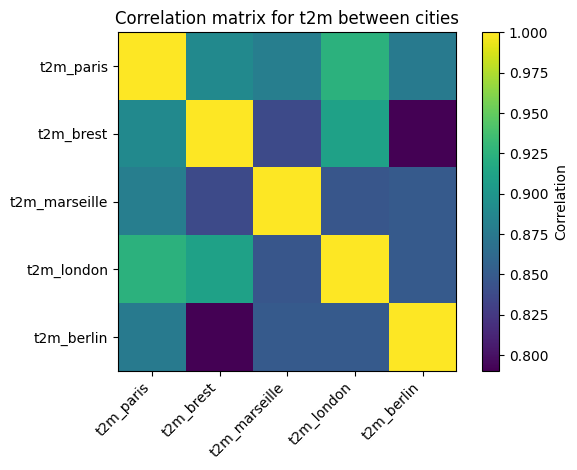

In [97]:
# Aperçu général
display(df_t2m.describe())

# Matrice de corrélation entre les 5 villes (t2m uniquement)
corr = df_t2m.corr()
corr

fig, ax = plt.subplots()
im = ax.imshow(corr.values, interpolation="nearest")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticklabels(corr.index)
plt.colorbar(im, ax=ax, label="Correlation")
plt.title("Correlation matrix for t2m between cities")
plt.tight_layout()
plt.show()



La température à Paris est fortement corrélée à celle de Brest et Londres, on devrait pouvoir la reconstruire à partir de ces données

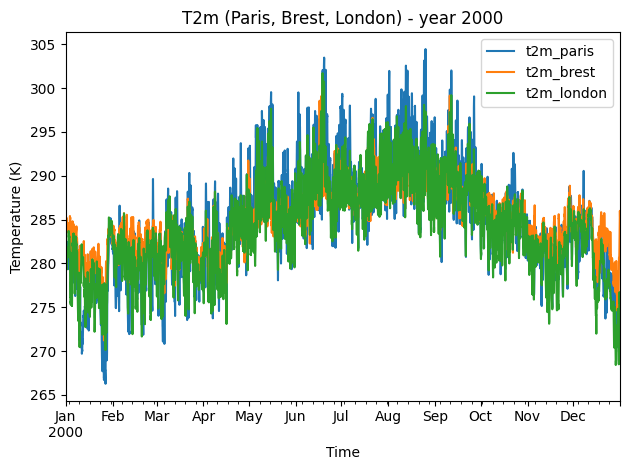

In [98]:
# On prend par exemple l'année 2000 pour ne pas avoir un plot énorme
df_2000 = df_t2m["2000-01-01":"2000-12-31"]

ax = df_2000[["t2m_paris", "t2m_brest", "t2m_london"]].plot()
ax.set_title("T2m (Paris, Brest, London) - year 2000")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (K)")
plt.tight_layout()
plt.show()


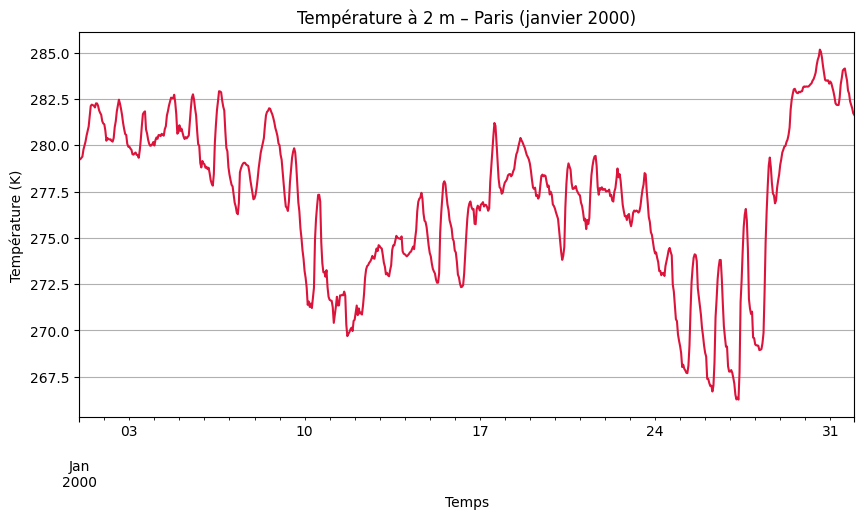

In [99]:
plt.figure(figsize=(10,5))
df_t2m.loc["2000-01", "t2m_paris"].plot(color="crimson")
plt.title("Température à 2 m – Paris (janvier 2000)")
plt.xlabel("Temps")
plt.ylabel("Température (K)")
plt.grid(True)
plt.show()


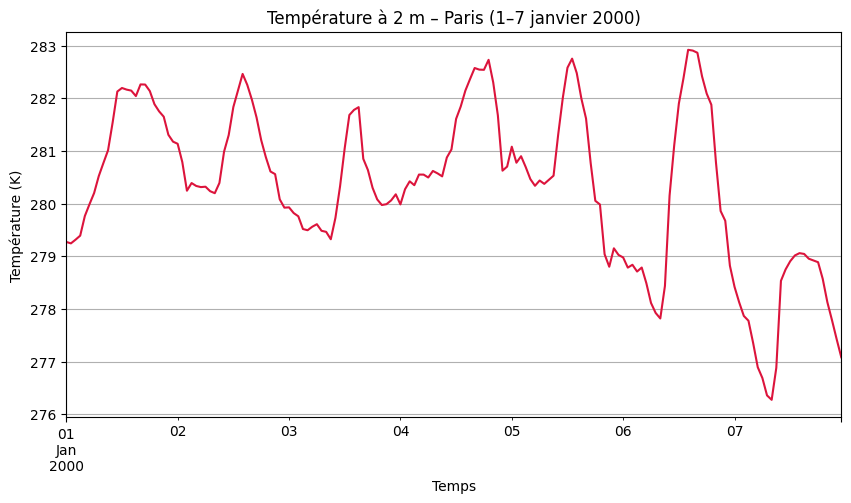

In [100]:
plt.figure(figsize=(10,5))
df_t2m.loc["2000-01-01":"2000-01-07", "t2m_paris"].plot(color="crimson")
plt.title("Température à 2 m – Paris (1–7 janvier 2000)")
plt.xlabel("Temps")
plt.ylabel("Température (K)")
plt.grid(True)
plt.show()


Sur l'année 2000, on observe bien que les températures dans les trois villes ont des tendances similaires

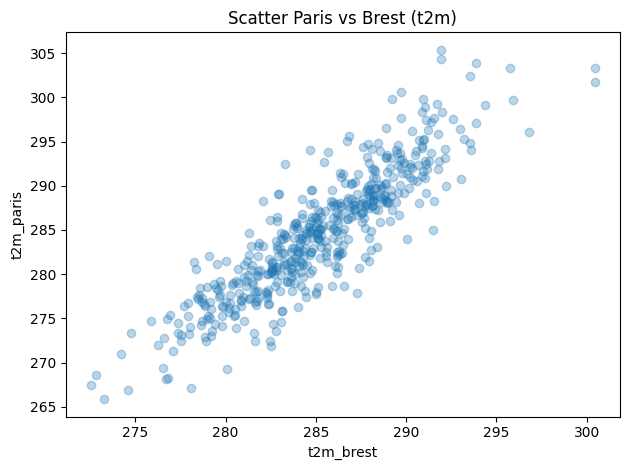

In [101]:
df_sample = df_t2m.sample(500)  # pour ne pas avoir 40 ans de points

plt.scatter(df_sample["t2m_brest"], df_sample["t2m_paris"], alpha=0.3)
plt.xlabel("t2m_brest")
plt.ylabel("t2m_paris")
plt.title("Scatter Paris vs Brest (t2m)")
plt.tight_layout()
plt.show()


## Premier modèle simple : régression linéaire

On choisit "t2m_paris" comme variable à prédire et on travaille sur des moyennes journalières

In [102]:
df_daily = df_t2m.resample("D").mean().dropna()

On split les données, train avant 2010 et test après 2010

In [103]:
target_col = "t2m_paris"
feature_cols = [c for c in df_daily.columns if c != target_col]

X = df_daily[feature_cols]
y = df_daily[target_col]

split_date = "2010-01-01"
X_train = X.loc[:split_date]
y_train = y.loc[:split_date]
X_test = X.loc[split_date:]
y_test = y.loc[split_date:]

X_train.shape, X_test.shape


((10959, 4), (3652, 4))

In [104]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE test:", rmse)
print("R² test :", r2)
print("Coefficients:")
for feat, coef in zip(feature_cols, model.coef_):
    print(f"  {feat}: {coef:.4f}")
print("Intercept:", model.intercept_)


RMSE test: 3.0489184856414795
R² test : 0.9280297756195068
Coefficients:
  t2m_brest: 0.3144
  t2m_marseille: 0.2116
  t2m_london: 0.4875
  t2m_berlin: 0.1842
Intercept: -56.624634


Le modèle reproduit bien les tendances avec un R² proche de 1

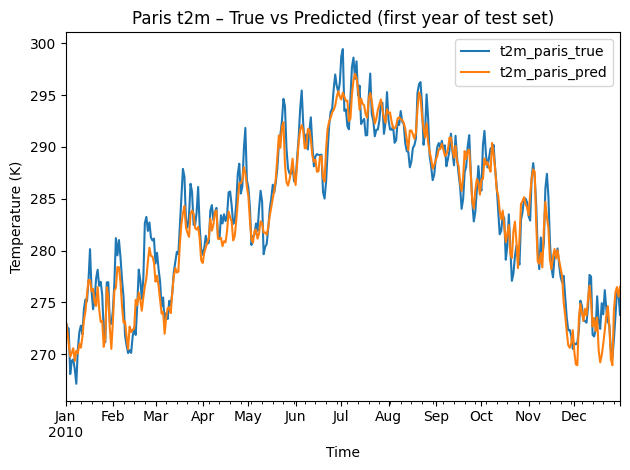

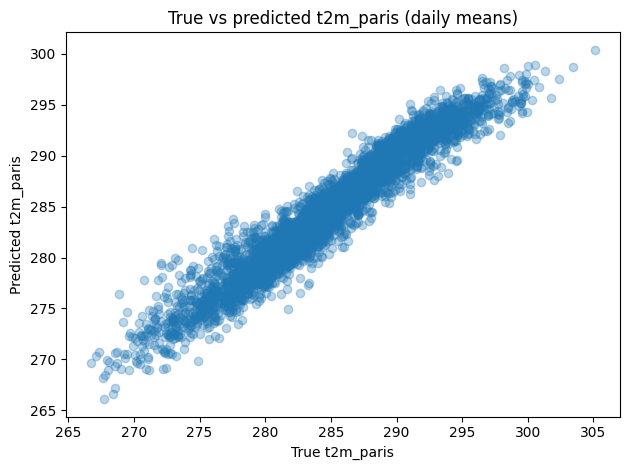

In [105]:
# Série temporelle : vérité vs prédiction
df_plot = pd.DataFrame(
    {
        "t2m_paris_true": y_test,
        "t2m_paris_pred": y_pred,
    },
    index=y_test.index,
)

ax = df_plot.iloc[:365].plot()  # par ex. première année du test
ax.set_title("Paris t2m – True vs Predicted (first year of test set)")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature (K)")
plt.tight_layout()
plt.show()

# Nuage de points vrai vs prédit
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("True t2m_paris")
plt.ylabel("Predicted t2m_paris")
plt.title("True vs predicted t2m_paris (daily means)")
plt.tight_layout()
plt.show()


<Axes: >

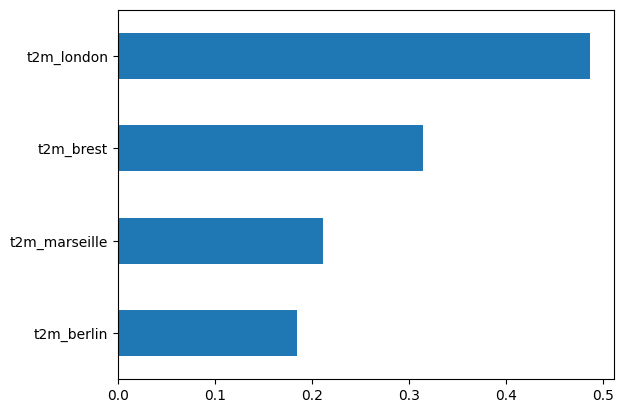

In [106]:
pd.Series(model.coef_, index=X.columns).sort_values().plot(kind="barh")

# Ajout de davantage de features

On s'inspire de la fonction précédente, mais pour plusieurs features cette fois ci

In [107]:
def load_city(city, variables):
    city_dir = base_dir / city
    dfs = []
    for var in variables:
        ds = xr.open_dataset(city_dir / f"{var}.nc")
        df = ds.to_dataframe()
        if isinstance(df.index, pd.MultiIndex): #ne garde que time en index
            df = df.droplevel([1, 2])
        dfs.append(df[[var]])
    df_city = pd.concat(dfs, axis=1)
    df_city.columns = [f"{v}_{city}" for v in variables]
    return df_city


In [114]:
vars_to_load = ["t2m", "sp", "tcc", "u10", "v10"]
cities = ["paris", "brest", "marseille", "london", "berlin"]

dfs = [load_city(c, vars_to_load) for c in cities]
df_all = pd.concat(dfs, axis=1, join="inner").resample("D").mean().dropna()
df_all.head()


,t2m_paris,sp_paris,tcc_paris,u10_paris,v10_paris,t2m_brest,sp_brest,tcc_brest,u10_brest,v10_brest,...,t2m_london,sp_london,tcc_london,u10_london,v10_london,t2m_berlin,sp_berlin,tcc_berlin,u10_berlin,v10_berlin
time,,,,,,,,,,,,,,,,,,,,,
1980-01-01,273.479401,99986.281250,0.971650,1.519432,0.049905,278.610992,100535.781250,0.908342,-2.907204,0.998717,...,271.535461,100482.742188,0.714395,1.780500,-2.129660,273.302643,99479.156250,0.768099,2.506452,0.168232
1980-01-02,273.006409,100941.804688,0.488950,2.593873,-2.803438,277.607880,101941.382812,0.629401,-1.086872,0.505969,...,271.127594,101516.968750,0.192993,2.360271,-2.286715,272.457001,100216.843750,0.920750,2.828004,-2.939709
1980-01-03,272.971161,101106.750000,0.993731,1.660924,2.719809,282.995911,101276.710938,1.000000,3.230666,6.318848,...,275.419586,100856.750000,0.997196,1.104568,4.380250,269.498505,101286.500000,0.624449,3.236282,-1.881103
1980-01-04,277.780121,99912.632812,0.995912,2.875389,4.083858,283.077545,100434.843750,0.795013,6.818993,1.603186,...,280.108887,99609.007812,0.693811,3.577985,3.042110,265.997406,101174.054688,0.394530,-0.393613,2.400102
1980-01-05,277.705780,99850.156250,0.705920,3.591074,1.608671,282.259979,100864.031250,0.575776,7.084157,-3.286267,...,277.335266,99777.281250,0.537025,4.093312,1.281889,269.789520,100354.367188,0.999382,-1.882274,1.898263


In [115]:
target = "t2m_paris"
features = [c for c in df_all.columns if c != target]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

X = df_all[features]
y = df_all[target]
split_date = "2010-01-01"
X_train, X_test = X.loc[:split_date], X.loc[split_date:]
y_train, y_test = y.loc[:split_date], y.loc[split_date:]

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² =", r2_score(y_test, y_pred))
print("RMSE =", root_mean_squared_error(y_test, y_pred))


R² = 0.9244884252548218
RMSE = 1.788558840751648


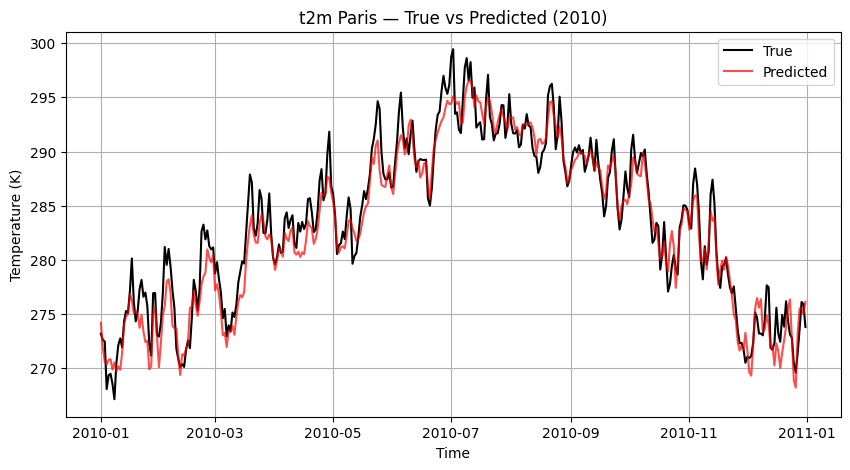

In [116]:
import matplotlib.pyplot as plt
import pandas as pd

# On remet les prédictions dans une série avec le même index que y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Sélectionne l'année 2010 et trace
plt.figure(figsize=(10,5))
plt.plot(y_test.loc["2010"], label="True", color="black")
plt.plot(y_pred_series.loc["2010"], label="Predicted", color="red", alpha=0.7)
plt.title("t2m Paris — True vs Predicted (2010)")
plt.xlabel("Time")
plt.ylabel("Temperature (K)")
plt.legend()
plt.grid(True)
plt.show()


<Axes: >

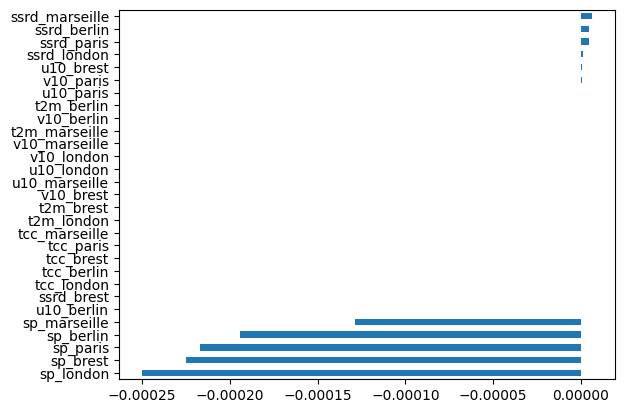

In [113]:
import pandas as pd
pd.Series(model.coef_, index=X.columns).sort_values().plot(kind="barh")


Si on ajoute ssrd ca devient horrible

On voit que la température à Paris peut être prédite avec une très bonne précision à partir des autres villes (R² = 0.92).
L’ajout d’autres variables météo améliore l’erreur absolue, ces paramètres apportent une information complémentaire, mais leurs coefficients sont significativement plus faibles.

# Rayonnement solaire

In [71]:
cities = ["paris", "brest", "marseille", "london", "berlin"]
var = "ssrd"

dfs = [load_city_var(c, var) for c in cities]
df_ssrd = pd.concat(dfs, axis=1, join="inner").sort_index()

Loading weather_data\paris\ssrd.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\brest\ssrd.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\marseille\ssrd.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\london\ssrd.nc
MultiIndex levels: ['time', 'latitude', 'longitude']
Loading weather_data\berlin\ssrd.nc
MultiIndex levels: ['time', 'latitude', 'longitude']


In [73]:
df_ssrd.head()
df_ssrd.describe()


,ssrd_paris,ssrd_brest,ssrd_marseille,ssrd_london,ssrd_berlin
count,3.506400e+05,3.506400e+05,3.506400e+05,3.506400e+05,3.506400e+05
mean,4.766921e+05,5.410271e+05,6.766223e+05,4.354909e+05,4.335112e+05
std,7.333958e+05,8.090641e+05,9.494721e+05,6.752937e+05,6.762124e+05
min,-1.901566e+00,-1.901566e+00,-1.901566e+00,-1.901566e+00,-1.901566e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.099200e+04,2.265600e+04,3.440000e+04,1.920000e+04,1.785600e+04
75%,7.495680e+05,8.680320e+05,1.220160e+06,6.744320e+05,6.552320e+05
max,3.315712e+06,3.361152e+06,3.558528e+06,3.223424e+06,3.160448e+06


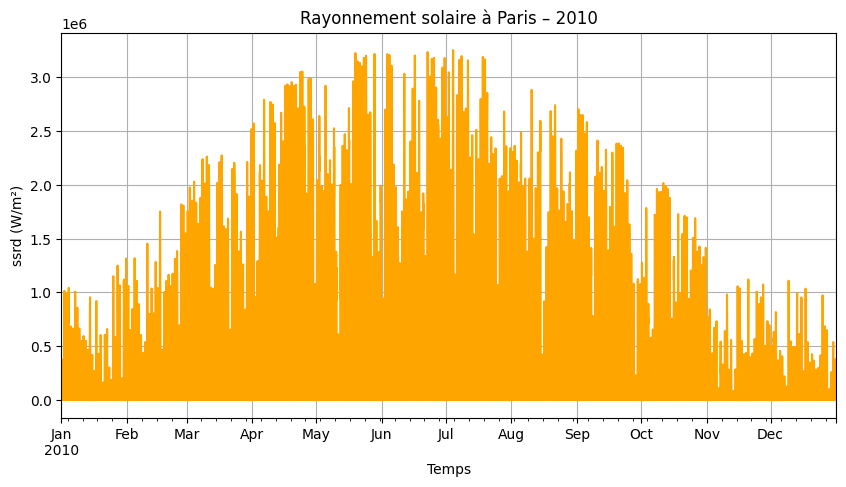

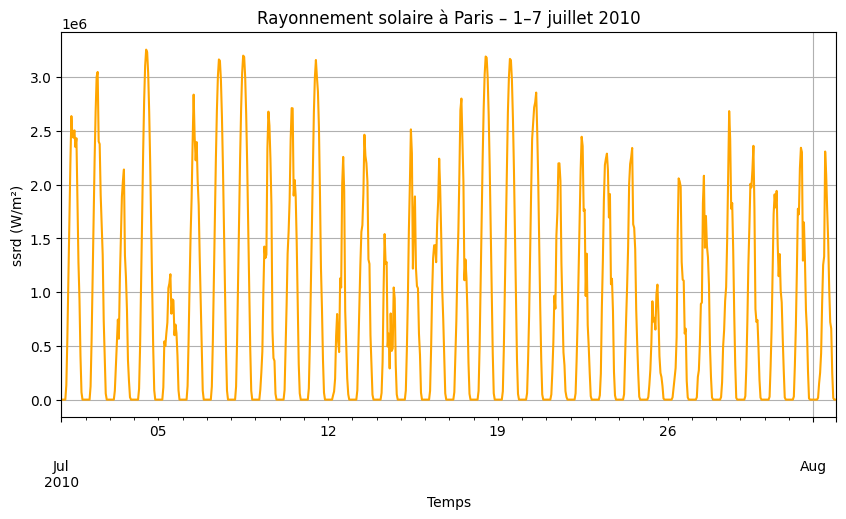

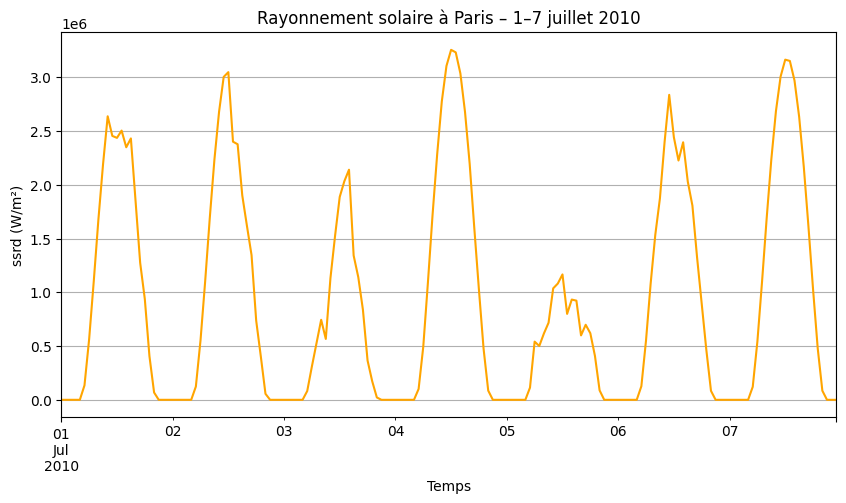

In [82]:
plt.figure(figsize=(10,5))
df_ssrd.loc["2010", "ssrd_paris"].plot(color="orange")
plt.title("Rayonnement solaire à Paris – 2010")
plt.ylabel("ssrd (W/m²)")
plt.xlabel("Temps")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
df_ssrd.loc["2010-07-01":"2010-08-01", "ssrd_paris"].plot(color="orange")
plt.title("Rayonnement solaire à Paris – 1–7 juillet 2010")
plt.ylabel("ssrd (W/m²)")
plt.xlabel("Temps")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
df_ssrd.loc["2010-07-01":"2010-07-07", "ssrd_paris"].plot(color="orange")
plt.title("Rayonnement solaire à Paris – 1–7 juillet 2010")
plt.ylabel("ssrd (W/m²)")
plt.xlabel("Temps")
plt.grid(True)
plt.show()




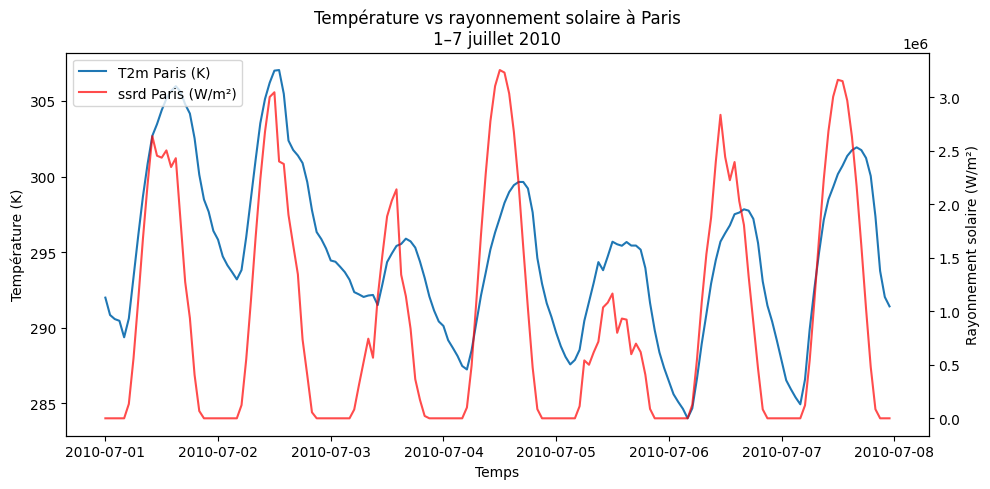

In [84]:
import matplotlib.pyplot as plt

# Période choisie : une semaine d'été
start, end = "2010-07-01", "2010-07-07"

# Séries temporelles pour Paris uniquement
t2m_paris_week = df_t2m.loc[start:end, "t2m_paris"]
ssrd_paris_week = df_ssrd.loc[start:end, "ssrd_paris"]

fig, ax1 = plt.subplots(figsize=(10, 5))

# Température (axe de gauche)
line1 = ax1.plot(t2m_paris_week, label="T2m Paris (K)")
ax1.set_xlabel("Temps")
ax1.set_ylabel("Température (K)")

# Rayonnement (axe de droite)
ax2 = ax1.twinx()
line2 = ax2.plot(ssrd_paris_week, color = 'red', label="ssrd Paris (W/m²)", alpha=0.7)
ax2.set_ylabel("Rayonnement solaire (W/m²)")

# Légende combinée
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("Température vs rayonnement solaire à Paris\n1–7 juillet 2010")
plt.tight_layout()
plt.show()


In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

vars_to_load = ["t2m", "sp", "tcc", "u10", "v10",'ssrd','blh']
cities = ["paris", "brest", "marseille", "london", "berlin"]

dfs = [load_city(c, vars_to_load) for c in cities]
df_all = pd.concat(dfs, axis=1, join="inner").resample("D").mean().dropna()

# Calcul de la matrice de corrélation
corr_matrix = df_all.corr()



<Axes: >

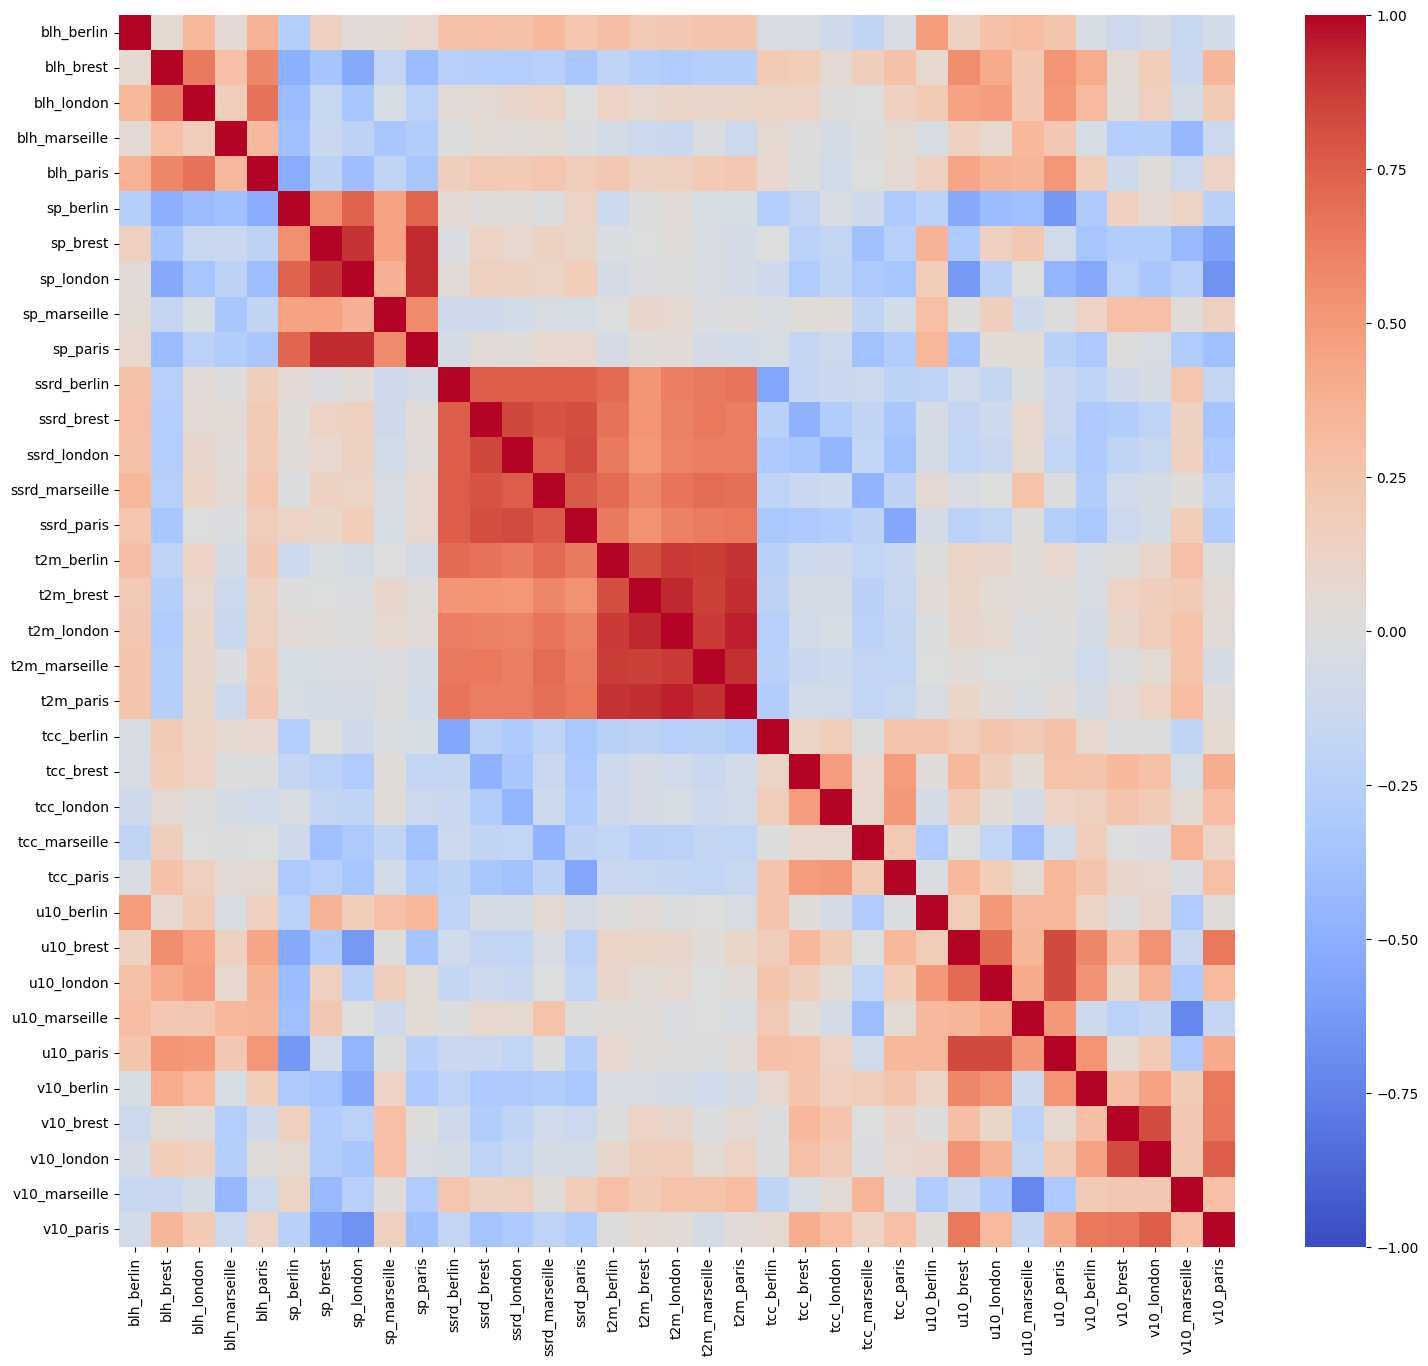

In [121]:
sorted_cols = sorted(df_all.columns)
plt.figure(figsize=(18,16))
sns.heatmap(corr_matrix.loc[sorted_cols, sorted_cols], cmap="coolwarm", vmin=-1, vmax=1)


In [123]:
corr_with_t2m = corr_matrix["t2m_paris"].sort_values(ascending=False)
corr_with_t2m.head(15)


t2m_paris         1.000000
t2m_london        0.946324
t2m_brest         0.914816
t2m_marseille     0.906724
t2m_berlin        0.901260
ssrd_marseille    0.686608
ssrd_berlin       0.665833
ssrd_paris        0.655720
ssrd_london       0.631281
ssrd_brest        0.631006
v10_marseille     0.312253
blh_berlin        0.249742
blh_paris         0.232054
v10_london        0.126133
blh_london        0.104827
Name: t2m_paris, dtype: float64

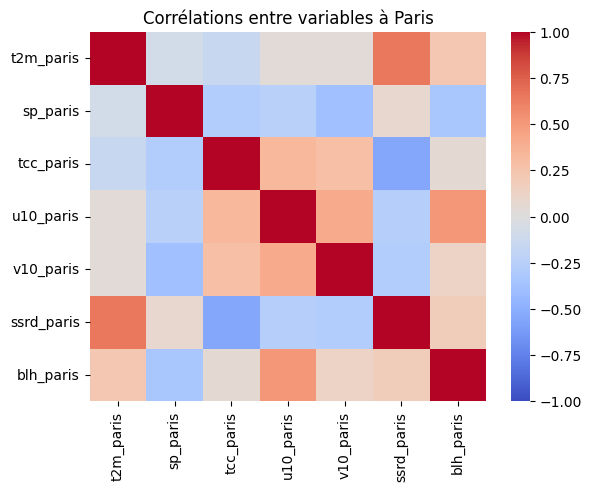

In [124]:
sns.heatmap(df_all.filter(like="_paris").corr(), cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Corrélations entre variables à Paris")
plt.show()


In [146]:
from sklearn.model_selection import train_test_split
import numpy as np


# Variables explicatives : t2m et ssrd de toutes les villes
X = df_all[
    [col for col in df_all.columns
     if (col.startswith("t2m_") or col.startswith("ssrd_"))
     and not col.endswith("_paris")]
]
print(X.columns)
y = df_all["t2m_paris"]

# Split train/test
split_date = "2010-01-01"
X_train, X_test = X.loc[:split_date], X.loc[split_date:]
y_train, y_test = y.loc[:split_date], y.loc[split_date:]

# Régression linéaire
reg = LinearRegression()
reg.fit(X_train, y_train)

# Prédictions
y_pred = reg.predict(X_test)

# Évaluation
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² test : {r2:.3f}")
print(f"RMSE test : {rmse:.3f}")
print("\nCoefficients :")
for col, coef in zip(X.columns, reg.coef_):
    print(f"  {col}: {coef:.6f}")
print(f"Intercept: {reg.intercept_:.4f}")

import numpy as np





Index(['t2m_brest', 'ssrd_brest', 't2m_marseille', 'ssrd_marseille',
       't2m_london', 'ssrd_london', 't2m_berlin', 'ssrd_berlin'],
      dtype='object')
R² test : 0.531
RMSE test : 4.458

Coefficients :
  t2m_brest: 0.000000
  ssrd_brest: 0.000001
  t2m_marseille: 0.000000
  ssrd_marseille: 0.000007
  t2m_london: 0.000000
  ssrd_london: 0.000003
  t2m_berlin: 0.000000
  ssrd_berlin: 0.000006
Intercept: 275.5715


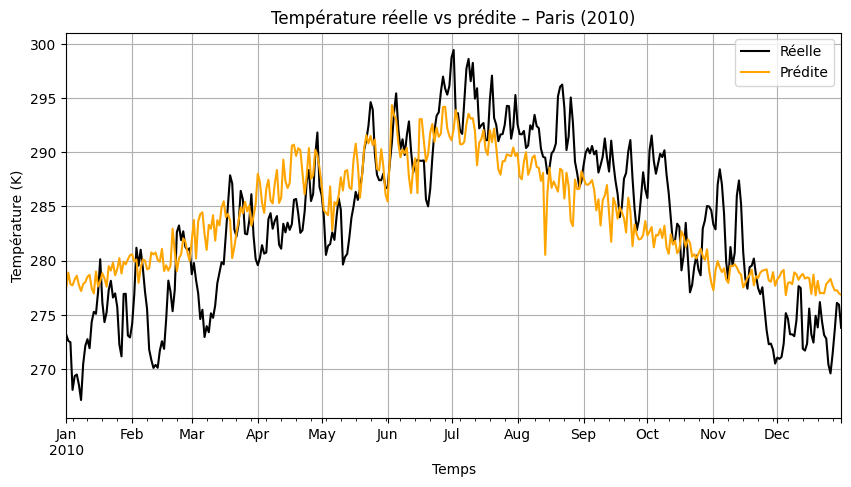

In [147]:
import matplotlib.pyplot as plt
import pandas as pd

# Créer un DataFrame pour comparer vrai vs prédit
df_compare = pd.DataFrame({
    "t2m_paris_true": y_test,
    "t2m_paris_pred": y_pred
}, index=y_test.index).sort_index()

month = "2010" 

plt.figure(figsize=(10,5))
df_compare.loc[month].plot(ax=plt.gca(), color=["black", "orange"])
plt.title(f"Température réelle vs prédite – Paris ({month})")
plt.ylabel("Température (K)")
plt.xlabel("Temps")
plt.grid(True)
plt.legend(["Réelle", "Prédite"])
plt.show()


# Idées à explorer

Evenements , par exemple :
 - canicule de 2003
 - vague de froid de 2012

 Introduire des différences de temps pour la propagation de vagues de froid etc ?

 Problème de classification

***
## Credit

[//]: # "This notebook is part of [E4C Interdisciplinary Center - Education](https://gitlab.in2p3.fr/energy4climate/public/education)."
Contributors include Bruno Deremble and Alexis Tantet.
Several slides and images are taken from the very good [Scikit-learn course](https://inria.github.io/scikit-learn-mooc/).

<br>

<div style="display: flex; height: 70px">
    
<img alt="Logo LMD" src="images/logos/logo_lmd.jpg" style="display: inline-block"/>

<img alt="Logo IPSL" src="images/logos/logo_ipsl.png" style="display: inline-block"/>

<img alt="Logo E4C" src="images/logos/logo_e4c_final.png" style="display: inline-block"/>

<img alt="Logo EP" src="images/logos/logo_ep.png" style="display: inline-block"/>

<img alt="Logo SU" src="images/logos/logo_su.png" style="display: inline-block"/>

<img alt="Logo ENS" src="images/logos/logo_ens.jpg" style="display: inline-block"/>

<img alt="Logo CNRS" src="images/logos/logo_cnrs.png" style="display: inline-block"/>
    
</div>

<hr>

<div style="display: flex">
    <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; margin-right: 10px" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>
    <br>This work is licensed under a &nbsp; <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.
</div>